# Virtual Travel Planning Agent:
## Done By:
* Aakar Mutha : aakar.mutha@nyu.edu

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
# General Imports
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_core.pydantic_v1 import BaseModel

from tavily import TavilyClient
import os

# LLM model import
from langchain_anthropic import ChatAnthropic

In [3]:
## Agent State Definition 
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    queries: List[str]
    answers: List[str]
    revision_number: int
    max_revisions: int

class Queries(BaseModel):
    queries: List[str]
    
    
## Configeration Variables
memory = SqliteSaver.from_conn_string(":memory:")

model = ChatAnthropic(model="claude-3-haiku-20240307")

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

## Defining Prompts

In [4]:
VACATION_PLANNING_SUPERVISOR_PROMPT="""You are the vacation planning supervisor. You have to give an outline of what the planning agent \
has to consider when planning the vacation according to the user input."""

PLANNER_ASSISTANT_PROMPT = """You are an assistant charged with providing information that can be used by the planner to plan the vacation.
Generate a list of search queries that will be useful for the planner. Generate a maximum of 3 queries."""

VACATION_PLANNER_PROMPT = """You are an expert vacation planner tasked with suggesting vacation itineraries.
You will provide the user with a suggestion of a vacation spot based on the outline and research.
If the user provides tweeks or changes respond with updated versions of the itineraries.
Always output a detailed daily itinerary in the following format even after integrating the suggestions:
------
Place:
Dates:
Estimated spending: xx USD
Mode of commute from <Origin>: yy
Estimated time to reach <Destination>: zzz Hrs vv Minutes
Itenary:
   Day 1: <DATE>
   - Things the user can do.
   - Things the user can do.
   - Things the user can do.
  
   Day 2: <DATE>
   - Things the user can do.
   - Things the user can do.
   - Things the user can do.
  
  
------   
Utilize the information below as needed:
------
{answers}"""

PLANNER_CRITIQUE_PROMPT = """Your duty is to criticize the planning done by the vacation planner.
In your response include if you agree with options presented by the planner, if not then give detailed suggestions on what should be changed.
You can also suggest some other destination that should be checked out.
"""

PLANNER_CRITIQUE_ASSISTANT_PROMPT = """You are a assistant charged with providing information that can be used to make any requested revisions.
Generate a list of search queries that will gather any relevent information. Only generate 3 queries max. 
You should consider the queries and answers that were previoulsy used:
QUERIES:
{queries}

ANSWERS:
{answers}
"""

In [5]:
# def instruction_node(state: AgentState):
#     messages = [
#         SystemMessage(content=VACATION_PLANNING_INSTRCTION_PROMPT),
#         HumanMessage(content=state['task'])
#     ]
#     task = model.invoke(messages)
#     return {'task' : task.content}

In [6]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=VACATION_PLANNING_SUPERVISOR_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    print("**********************************************************")
    print("Plan: ")
    print(response.content)
    print("**********************************************************")
    return {"plan": response.content}

In [7]:
def research_plan_node(state: AgentState):
    pastQueries = state['queries'] or []
    answers = state['answers'] or []
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=PLANNER_ASSISTANT_PROMPT),
        HumanMessage(content=state['plan'])
    ])   
    print("**********************************************************")
    print("Queries and Response: ")
    for q in queries.queries:
        print("Query: " + q)
        pastQueries.append(q)
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            print("Tavily Response: " + r['content'])
            answers.append(r['content'])
    print("**********************************************************")
    return {
        "queries": pastQueries,
        "answers": answers
        }

In [8]:
def generation_node(state: AgentState):
    answers = "\n\n".join(state['answers'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=VACATION_PLANNER_PROMPT.format(answers=answers)
        ),
        user_message
        ]
    response = model.invoke(messages)
    print("**********************************************************")
    print("Draft: ")
    print(response.content)
    print("**********************************************************")
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [9]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=PLANNER_CRITIQUE_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    print("**********************************************************")
    print("Critique: ")
    print(response.content)
    print("**********************************************************")
    return {"critique": response.content}

In [10]:
def research_critique_node(state: AgentState):
    pastQueries = state['queries'] or []
    answers = state['answers'] or []
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=PLANNER_CRITIQUE_ASSISTANT_PROMPT.format(queries=pastQueries, answers=answers)),
        HumanMessage(content=state['critique'])
    ])
    print("**********************************************************")
    print("Queries and Response:")
    for q in queries.queries:
        print("Query: " + q)
        pastQueries.append(q)
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            print("Tavily Response: " + r['content'])
            answers.append(r['content'])
    print("**********************************************************")       
    return {
        "queries": pastQueries,
        "answers": answers
        }

In [11]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [12]:
builder = StateGraph(AgentState)

builder.add_node("planner", plan_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_critique", research_critique_node)

builder.set_entry_point("planner")

builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [13]:
graph = builder.compile(checkpointer=memory)

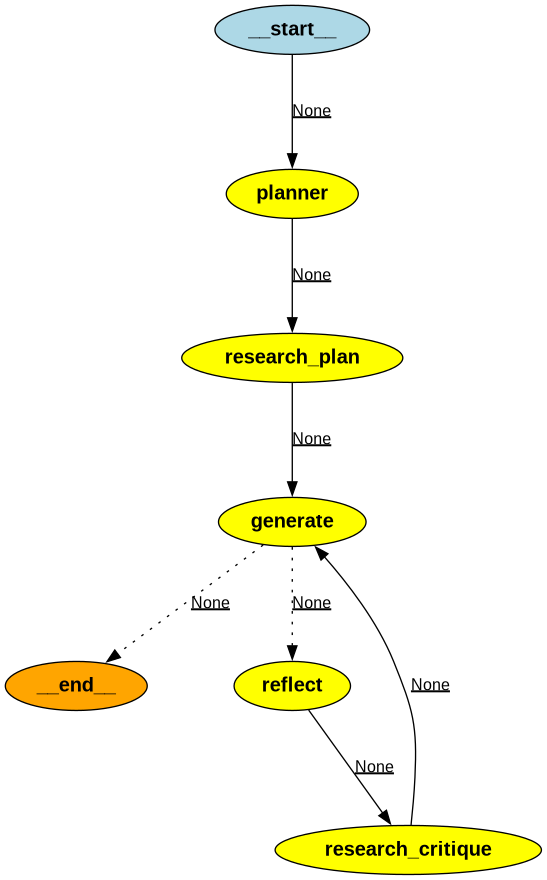

In [14]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [15]:
thread = {"configurable": {"thread_id": "4"}}
output = []
streamOptions = {
    'task': "Suggest me a day trip for a group of 4 friends all residing in NYC.",
    "max_revisions": 3,
    "revision_number": 1,
}
for s in graph.stream(streamOptions, thread):
    output.append(s)

**********************************************************
Plan: 
Certainly! Here's an outline of what the planning agent should consider when planning a day trip for a group of 4 friends residing in NYC:

I. Destination Selection
   A. Proximity to NYC
      1. Consider destinations within a 2-3 hour drive from NYC
      2. Prioritize destinations that are easily accessible by public transportation or car
   B. Diverse Interests
      1. Cater to the varied interests of the group (e.g., nature, history, culture, food)
      2. Ensure the destination offers a range of activities to accommodate everyone's preferences

II. Transportation
   A. Mode of Transportation
      1. Evaluate the best mode of transportation (e.g., private car, train, bus)
      2. Consider the group's comfort and convenience
   B. Parking Availability
      1. Assess the parking situation at the destination
      2. Provide guidance on parking options and costs

III. Itinerary Planning
   A. Prioritize Must-See A

### UI using GRADIO

In [16]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [17]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
